In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data
import matplotlib.pyplot as plt 
import os
from PIL import Image, ImageDraw, ImageFont

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
import random
def create_mask(height, width, min_opacity=0.1, max_opacity=0.25):

    mask_h = random.randint(int(height * .7), int(height * .9))
    mask_w = random.randint(int(width * .1), int(width * .3))
    opacity = min_opacity + torch.rand((1,1,1), device=device)*(max_opacity - min_opacity)
    opacity.reshape(-1,1,1)
    max_angle = random.uniform(-1.5, 1.5)

    mask = torch.cuda.FloatTensor(3, mask_h, mask_w).fill_(1) * opacity
    mask *= float(random.randint(0, 2) * 2 - 1)
    
    y_pos = random.randint(0, height - mask_h)
    x_pos = random.randint(0, width - mask_w)
    mask = F.pad(mask, (x_pos, width - mask_w - x_pos, y_pos, height - mask_h - y_pos))

#     mask = transforms.RandomRotation((-10, 10))  # Costly
    return mask

In [4]:
def batch_mask(batch_size, height, width, min_opacity=0.1, max_opacity=0.3):
    return torch.cat([
        torch.unsqueeze(
            create_mask(height, width, min_opacity, max_opacity), 0) 
        for _ in range(batch_size)], 0)
    

In [5]:
def get_data_loader(batch_size):
    
    transform = transforms.Compose([transforms.Resize((150, 250)), transforms.ToTensor()])
    
    ori_data = torchvision.datasets.ImageFolder('resized_images/wide', transform = transform)

#     labeled_data = ConcatDataset(ori_data, data)
    
    trainLen = int(0.6*len(ori_data))
    valLen = int(0.2*len(ori_data))
    testLen = int(0.2*len(ori_data))
    
    train_data, val_data, test_data = torch.utils.data.random_split \
    (ori_data, [trainLen, valLen, testLen])
    
    train_data_loader = torch.utils.data.DataLoader(train_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    val_data_loader = torch.utils.data.DataLoader(val_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    test_data_loader = torch.utils.data.DataLoader(test_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    
    return train_data_loader, val_data_loader, test_data_loader

In [6]:
# NOTE: THIS ONLY USES ONE FOLDER!
train_data_loader, val_data_loader, test_data_loader = get_data_loader(5)
print(len(train_data_loader), len(val_data_loader), len(test_data_loader))

165 55 55


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


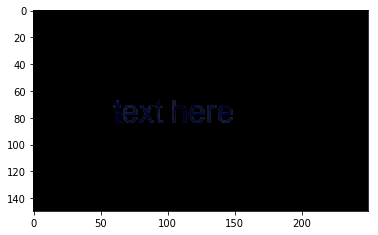

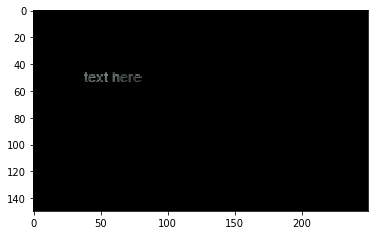

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


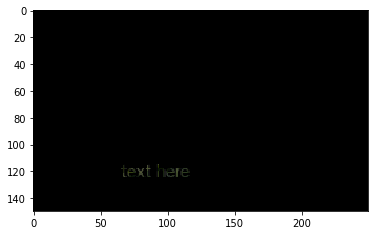

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


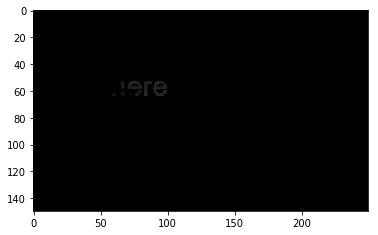

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


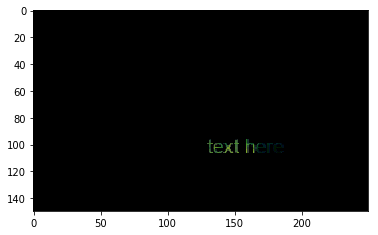

In [32]:
original, _ = next(iter(test_data_loader))
txtlist = []
for im in original:
    pil = transforms.ToPILImage()
    base = pil(im).convert("RGBA")
    font = ImageFont.truetype("arial.ttf", random.randint(10, 25))
    colour = (random.randint(50, 250), random.randint(50, 250), random.randint(50, 250), random.randint(100, 200))
    txt = Image.new('RGBA', base.size, (255, 255, 255, 0))
    pos = (random.randint(0, 150), random.randint(0, 120))
    drawing = ImageDraw.Draw(txt)
    drawing.text(pos, "text here", fill=colour, font=font)
    combined = Image.alpha_composite(base, txt).convert("RGB")
    tensor = transforms.ToTensor()
    text = tensor(combined)
#     k = np.transpose((text-im), [1,2,0])
#     plt.imshow(k)
#     plt.show()
    txtlist.append(text)
text = torch.stack(txtlist)
# original = original.cuda()[0]
# mask = batch_mask(1, 150, 250)
# mask.to(device)

# water_img = torch.clamp(original - mask, 0, 1)
# water_img.to(device)

# original = original.cpu()
# original = np.transpose(original, [1,2,0])
# water_img = water_img.cpu()[0]
# water_img = np.transpose(water_img, [1,2,0])

# plt.imshow(original)
# plt.show()

# plt.imshow(water_img)
# plt.show()

In [8]:
def conv3x3(in_channels, out_channels, stride=1):
        return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                         stride=stride, padding=1, bias=False)

class testResNetBlocks(nn.Module):

    def load_weights(self, layername):
        an_builtin = models.resnet18(pretrained=True) # Loads the pretrained model weights
        
        own_state = self.state_dict()
        
        for (name, layer) in an_builtin._modules.items():
            if name == layername:
                self.conv1.weight = layer[0]._modules['conv1'].weight
                self.conv2.weight = layer[0]._modules['conv2'].weight
            if layername == name+"-":
                self.conv1.weight = layer[1]._modules['conv1'].weight
                self.conv2.weight = layer[1]._modules['conv2'].weight
    
    def __init__(self, in_channels, out_channels, layername, stride=1, downsample=None):
        super(testResNetBlocks, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.load_weights(layername)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [9]:
class DilatedResNet(nn.Module):
    def __init__(self, block):
        super(DilatedResNet, self).__init__()
        
        self.in_channels = 64
        self.bottleneck_channels = 16
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.layers1 = self.make_layer(block, 64, "layer1")
#         self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
#         self.layers2 = self.make_layer(block, 128, "layer2")
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, self.bottleneck_channels, 3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU(),
#             nn.ConvTranspose2d(64, self.bottleneck_channels, 2, stride=1, padding=1, dilation=2),
#             nn.BatchNorm2d(self.bottleneck_channels),
#             nn.ReLU(),
            nn.ConvTranspose2d(self.bottleneck_channels, self.bottleneck_channels, 3, stride=1, \
                               padding=4, dilation=4),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(self.bottleneck_channels, self.bottleneck_channels, 3, stride=1, \
                               padding=2, dilation=2),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU(),
#             nn.ConvTranspose2d(16, 3, 3, stride=1, padding=2, output_padding = 1, dilation=2),
#             nn.BatchNorm2d(3),
            nn.ConvTranspose2d(self.bottleneck_channels, 3, 3, padding=1),
#             nn.ConvTranspose2d(32, 3, 3)
#             nn.Sigmoid()
        )
    
    def make_layer(self, block, out_channels, layername, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, layername, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, 2):
            layers.append(block(out_channels, out_channels, layername+"-"))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layers1(x)
#         x = self.conv2(x)
#         x = self.layers2(x)
#         x = self.conv3(x)
#         x = self.layers3(x)
        x = self.decoder(x)
        return x

In [10]:
import string
def randomString(stringLength):
    """Generate a random string with the combination of lowercase and uppercase letters """
    letters = string.ascii_letters
    return ''.join(random.choice(letters) for i in range(stringLength))

In [33]:
def train(model, batch_size, num_epochs=5, learning_rate=1e-4):    
    train_loader, val_loader, test_loader = get_data_loader(batch_size)
    
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss = np.zeros(num_epochs)
    
    outputs = []
    for epoch in range(num_epochs):
        total_err = 0.0
        total_loss = 0.0
        total_epoch = 0
        
        i = 0
        for original, _ in train_loader:
            txtlist = []
            for im in original:
                pil = transforms.ToPILImage()
                base = pil(im).convert("RGBA")
                font = ImageFont.truetype("arial.ttf", random.randint(10, 25))
                colour = (random.randint(50, 250), random.randint(50, 250), random.randint(50, 250), random.randint(100, 200))
                txt = Image.new('RGBA', base.size, (255, 255, 255, 0))
                pos = (random.randint(0, 150), random.randint(0, 120))
                drawing = ImageDraw.Draw(txt)
                s = randomString(random.randint(3,10))
                drawing.text(pos, s, fill=colour, font=font)
                combined = Image.alpha_composite(base, txt).convert("RGB")
                tensor = transforms.ToTensor()
                text = tensor(combined)
            #     k = np.transpose((text-im), [1,2,0])
            #     plt.imshow(k)
            #     plt.show()
                txtlist.append(text)
            text = torch.stack(txtlist)            
            
            original = original.cuda()
            text = text.cuda()
            mask = text - original

            mask_pred = model(text)
            
            loss = criterion(mask_pred, mask)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
        train_loss[epoch] = float(total_loss) / (i+1)
#         print("Epoch %d; Loss %f" % (epoch+1, train_loss[epoch]))
            
    return outputs

In [41]:
# model = DilatedResNet(testResNetBlocks)
model = torch.load("model_c.pt")
model.to(device)
lr = 0.000512
for i in range(9):
    outputs = train(model, batch_size=32, learning_rate=lr, num_epochs=30)
    lr /= 2
    torch.save(model, 'model_c.pt')

Epoch 1; Loss 0.001579
Epoch 2; Loss 0.001469
Epoch 3; Loss 0.001371
Epoch 4; Loss 0.001412
Epoch 5; Loss 0.001565
Epoch 6; Loss 0.001503
Epoch 7; Loss 0.001412
Epoch 8; Loss 0.001357
Epoch 9; Loss 0.001464
Epoch 10; Loss 0.001334
Epoch 11; Loss 0.001319
Epoch 12; Loss 0.001424
Epoch 13; Loss 0.001392
Epoch 14; Loss 0.001409
Epoch 15; Loss 0.001345
Epoch 16; Loss 0.001429
Epoch 17; Loss 0.001483
Epoch 18; Loss 0.001367
Epoch 19; Loss 0.001411
Epoch 20; Loss 0.001373
Epoch 21; Loss 0.001424
Epoch 22; Loss 0.001389
Epoch 23; Loss 0.001335
Epoch 24; Loss 0.001318
Epoch 25; Loss 0.001370
Epoch 26; Loss 0.001408
Epoch 27; Loss 0.001354
Epoch 28; Loss 0.001360
Epoch 29; Loss 0.001381
Epoch 30; Loss 0.001303
Epoch 1; Loss 0.001267
Epoch 2; Loss 0.001271
Epoch 3; Loss 0.001326
Epoch 4; Loss 0.001273
Epoch 5; Loss 0.001340
Epoch 6; Loss 0.001324
Epoch 7; Loss 0.001336
Epoch 8; Loss 0.001290
Epoch 9; Loss 0.001284
Epoch 10; Loss 0.001310
Epoch 11; Loss 0.001364
Epoch 12; Loss 0.001300
Epoch 13; 

In [36]:
torch.save(model, 'model_c.pt')

torch.Size([3, 150, 250])


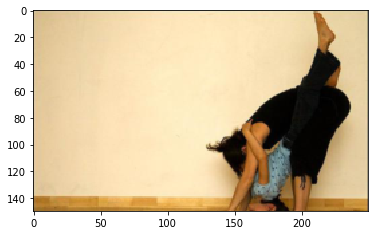

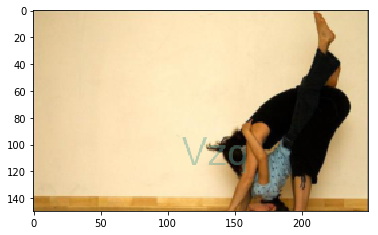

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


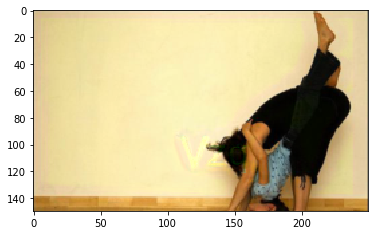

In [51]:
train_data_loader, val_data_loader, test_data_loader = get_data_loader(5)
original, _ = next(iter(test_data_loader))
txtlist = []
for im in original:
    pil = transforms.ToPILImage()
    base = pil(im).convert("RGBA")
    font = ImageFont.truetype("arial.ttf", random.randint(20, 30))
    colour = (random.randint(50, 250), random.randint(50, 250), random.randint(50, 250), random.randint(100, 200))
    txt = Image.new('RGBA', base.size, (255, 255, 255, 0))
    pos = (random.randint(0, 150), random.randint(0, 120))
    drawing = ImageDraw.Draw(txt)
    s = randomString(random.randint(3,8))
    drawing.text(pos, s, fill=colour, font=font)
    combined = Image.alpha_composite(base, txt).convert("RGB")
    tensor = transforms.ToTensor()
    text = tensor(combined)
#     k = np.transpose((text-im), [1,2,0])
#     plt.imshow(k)
#     plt.show()
    txtlist.append(text)
text = torch.stack(txtlist)
original = original.cuda()
text = text.cuda()
mask = text - original
mask_pred = model(text)

recon = text - mask_pred

original = original.cpu()[0]
print(original.shape)
original = np.transpose(original, [1,2,0])
text = text.cpu()[0]
text = np.transpose(text, [1,2,0])
mask = mask.cpu()[0]
mask = np.transpose(mask, [1,2,0])
recon = recon.cpu()[0]
recon = np.transpose(recon.detach(), [1,2,0])
mask_pred = mask_pred.cpu()[0]
mask_pred = np.transpose(mask_pred.detach(), [1,2,0])

plt.imshow(original)
plt.show()

# plt.imshow(mask)
# plt.show()

plt.imshow(text)
plt.show()

plt.imshow(recon)
plt.show()

# plt.imshow(mask_pred)
# plt.show()
